<a href="https://colab.research.google.com/github/Dioriza/Tensorflow-Project/blob/master/Sentiment_Analysis_Gojek_Bi_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Package

In [ ]:
import pandas as pd
import numpy as np
import zipfile
import re

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential

# Import Dataset

Dataset yang akan dijadikan uji sentiment analysis adalah Dataset review aplikasi Gojek yang terdapat di playstore. Memiliki dua sentiment yang akan dianalisa yaitu **Positive** dan **Negative**

In [ ]:
!wget https://github.com/WiraDKP/word_vector/raw/master/22%20-%20Word%20Vector/data.zip

--2020-09-06 10:41:07--  https://github.com/WiraDKP/word_vector/raw/master/22%20-%20Word%20Vector/data.zip
Resolving github.com (github.com)... 140.82.118.4
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/WiraDKP/word_vector/master/22%20-%20Word%20Vector/data.zip [following]
--2020-09-06 10:41:07--  https://raw.githubusercontent.com/WiraDKP/word_vector/master/22%20-%20Word%20Vector/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 184047 (180K) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>] 179.73K  --.-KB/s    in 0.01s   

2020-09-06 10:41:08 (13.8 MB/s) - ‘data.zip’ saved [184047/184047]



In [ ]:
local_zip = 'data.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
df = pd.read_csv('/tmp/data/gojek_review_sentiment.csv')
df.head()

,review,rate
0,Apa aplikasi yang bagus untuk dengan mudah per...,positive
1,Aplikasi ini banyak membantu saya. Sekarang sa...,positive
2,Mengerikan. Antarmukanya sangat membingungkan....,negative
3,Aplikasi yang cukup mengesankan. Butuh waktu l...,positive
4,Aplikasi ini sebenarnya bagus dan sangat memba...,positive


In [ ]:
df.shape

(1782, 2)

In [ ]:
df['review'][0]

'Apa aplikasi yang bagus untuk dengan mudah pergi ke mana saja jika kita tidak memiliki sepeda motor atau ingin pergi dalam perjalanan kelompok, kita dapat menggunakan gocar dan perjalanan yang menyenangkan adalah suatu keharusan, jadi saya pikir gojek memberi kita banyak situasi nyaman selama mengendarai. Dan saya suka gofood! Saya pikir itu sudah cukup.'

# Data Cleaning

In [ ]:
#copy dataset for evaluate
df_before = df.copy()

def review_cleaning(text):
    
    # delete lowercase and newline
    text = text.lower()
    text = re.sub(r'\n', '', text)
    
    # delete punctuation
    text = re.sub('[^a-z0-9 ]', ' ', text)
    
    tokenizer = text.split()
    
    return ' '.join([text for text in tokenizer])

In [ ]:
df['review'] = df['review'].apply(review_cleaning)

In [ ]:
test = "Aku seeeeneeeeeng bangggeeeettt make Gofood. Jadi simple semuanyaaaa. beneeeraaaan tidak usah repot keluar rumah"
print(re.sub(r'(\w)\1{2,}', r'\1', test))

Aku seneng banget make Gofood. Jadi simple semuanya. beneran tidak usah repot keluar rumah


In [ ]:
def delete_repeated_char(text):
    
    text = re.sub(r'(\w)\1{,}', r'\1', text)
    
    return text

In [ ]:
df['review'] = df['review'].apply(delete_repeated_char)

In [ ]:
print('Before: ', df_before.loc[674, 'review'])
print('After: ', df.loc[674, 'review'])

print('\nBefore: ', df_before.loc[1441, 'review'])
print('After: ', df.loc[1441, 'review'])

Before:  update jadi banyak masalah .. server sibuk .. top up susah .. ga banyak pilihan .. soooo baaad
After:  update jadi banyak masalah server sibuk top up susah ga banyak pilihan so bad

Before:  Berguna! tidak hanya untuk transportasi tetapi juga untuk pembayaran, restoran dll. Loveeeee it ..
After:  berguna tidak hanya untuk transportasi tetapi juga untuk pembayaran restoran dl love it


# Data Preparation

In [ ]:
df['rate'] = df['rate'].replace({'positive': 1})
df['rate'] = df['rate'].replace({'negative': 0})
df['rate'].value_counts()

0    1061
1     721
Name: rate, dtype: int64

In [ ]:
X = df['review'].values
y = df['rate'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1425,), (357,), (1425,), (357,))

In [ ]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "~"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(X_train)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)


# Model LSTM Bidirectional

Cara kerja dari LSTM Bidirectional adalah menjalankan input dua arah kedalam dua cara, satu dari masa lalu ke masa depan dan satu dari masa depan ke masa lalu dan apa yang berbeda dari pendekatan ini adalah berbeda dengan Unidirectional LSTM yang berjalan mundur saat menyimpan informasi dari masa depan dan menggunakan dua *hidden state* digabungkan pada suatu pada suatu titik waktu untuk menyimpan informasi dari masa lalu dan masa depan.

Point pentingnya adalah Bidirectional LSTM menunjukkan hasil yang sangat baik karena mereka dapat memahami konteks dengan lebih baik, saya akan mencoba menjelaskan melalui contoh.

Katakanlah kita mencoba untuk memprediksi kata berikutnya dalam sebuah kalimat, pada tingkat tinggi apa yang LSTM searah akan lihat adalah

**Anak-anak pergi ke ....**

Dan akan mencoba memprediksi kata berikutnya hanya dengan konteks ini, dengan Bidirectional LSTM akan dapat melihat informasi lebih jauh kedepan misalnya

Forward LSTM:

**Anak-anak pergi ke ...**

Backward LSTM:

**... dan kemudian mereka keluar dari kolam renang**

Dan cara ini juga bisa diterapkan melalui klasifikasi sentiment pada data tidak terstruktur seperti text. dan *it works* Karena pada dasarnya Gagasan di balik bidirectional adalah untuk menangkap informasi input sekitarnya. alhasil belajar lebih cepat daripada pendekatan satu arah.

![alt text](https://miro.medium.com/max/609/1*c4yHwRQESwG5e0WsmW-zBw.gif)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=10)

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           16000     
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               93600     
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               102912    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 213,025
Trainable params: 213,025
Non-trainable params: 0
__________________________________________________

In [ ]:
num_epochs = 100

history = model.fit(training_padded, y_train, epochs=num_epochs, 
                    validation_data=(testing_padded, y_test), verbose=2, callbacks=[callback])

Epoch 1/100
45/45 - 7s - loss: 0.6246 - accuracy: 0.6470 - val_loss: 0.4715 - val_accuracy: 0.7815
Epoch 2/100
45/45 - 6s - loss: 0.3394 - accuracy: 0.8695 - val_loss: 0.2626 - val_accuracy: 0.9132
Epoch 3/100
45/45 - 6s - loss: 0.2175 - accuracy: 0.9270 - val_loss: 0.2281 - val_accuracy: 0.9216
Epoch 4/100
45/45 - 6s - loss: 0.1513 - accuracy: 0.9488 - val_loss: 0.2250 - val_accuracy: 0.9300
Epoch 5/100
45/45 - 6s - loss: 0.1107 - accuracy: 0.9663 - val_loss: 0.2800 - val_accuracy: 0.9216
Epoch 6/100
45/45 - 6s - loss: 0.0885 - accuracy: 0.9684 - val_loss: 0.3040 - val_accuracy: 0.9076
Epoch 7/100
45/45 - 6s - loss: 0.0612 - accuracy: 0.9782 - val_loss: 0.3264 - val_accuracy: 0.9216
Epoch 8/100
45/45 - 6s - loss: 0.0411 - accuracy: 0.9867 - val_loss: 0.4322 - val_accuracy: 0.9104
Epoch 9/100
45/45 - 6s - loss: 0.0201 - accuracy: 0.9937 - val_loss: 0.4511 - val_accuracy: 0.9076
Epoch 10/100
45/45 - 6s - loss: 0.0133 - accuracy: 0.9965 - val_loss: 0.5172 - val_accuracy: 0.9160
Epoch 11/

# Plot Accuracy

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

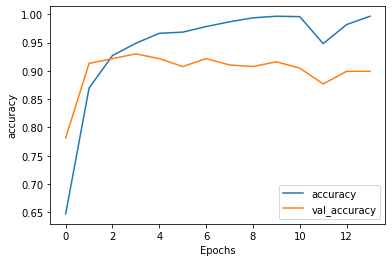

In [ ]:
plot_graphs(history, 'accuracy')

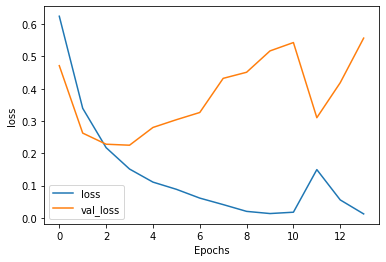

In [ ]:
plot_graphs(history, 'loss')

# Testing Model

In [ ]:
def get_word(x):
  x = tokenizer.texts_to_sequences(x)
  x = pad_sequences(x, maxlen=50, padding="post")
  return x

In [ ]:
negative = ['aplikasi ini tidak berguna, scam, penipuan. Saya merasa dirugikan dengan aplikasi ini']
positive = ['aplikasi ini sangat membantu hidup saya sehari-hari lewat layanan yang mudah digunakand seperti Gofood']

n_sentiment = get_word(negative)
p_sentiment = get_word(positive)

In [ ]:
pred = model.predict_classes(n_sentiment)
print(negative,'\n', "Kalimat ini bermakna negatif, masuk kedalam kelas: \n", pred )

['aplikasi ini tidak berguna, scam, penipuan. Saya merasa dirugikan dengan aplikasi ini'] 
 Kalimat ini bermakna negatif, masuk kedalam kelas: 
 [[0]]


In [ ]:
pred = model.predict_classes(p_sentiment)
print(positive,'\n', "Kalimat ini bermakna negatif, masuk kedalam kelas: \n", pred )

['aplikasi ini sangat membantu hidup saya sehari-hari lewat layanan yang mudah digunakand seperti Gofood'] 
 Kalimat ini bermakna negatif, masuk kedalam kelas: 
 [[1]]


# Save Model

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
model.save('/content/gdrive/My Drive/sentiment_app')

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/sentiment_app/assets


## Referensi 

- Bi-LSTM, https://medium.com/@raghavaggarwal0089/bi-lstm-bc3d68da8bd0
- Dataset, https://github.com/WiraDKP
- Konsep Bi-LSTM, https://www.youtube.com/watch?v=Bp-_DatyUCY